# Classificação dos niveis de MHI, usando dados sociodemograficos e do WHOQOL-BREF;
- Neste projeto será utilizado a base de dados da dissertação "QUALIDADE DE VIDA E SAÚDE MENTAL DE ESTUDANTES UNIVERSITÁRIOS" de autoria de LYCÉLIA DA SILVA OLIVEIRA, para usar dados sociodemograficos e de qualidade de vida para classificar os niveis de saude mental dos estudantes universitarios da UVA.

## 1 - Importando Dados e Bibliotecas

In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

#Importando modelos de machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [2]:
# Importando base de dados que contem o header
base = pd.read_csv('df_social_whoqol_tratado_1.csv')

# Dividindo entre X e y, pelo tamanho da base
X = base.drop('Nivel_MHI', axis=1)
y = base['Nivel_MHI']


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

## 2 - Classificação com Modelos Baseline;
Inicialmente será testado alguns modelos baseline para verificar qual apresenta o melhor resultado, sem aplicar nenhum tipo de tratamento nos dados. Usei como baseline os seguintes modelos:
- (1) DummyClassifier
- (2) SVM
- (3) Random Forest
- (4) MLP
- (5) XGBoost
- (6) KNN

### 2.1 - Importando as bibliotecas necessárias;

In [3]:
# Importando as bibliotecas necessárias
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Importando os modelos de classificação
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

### 2.2 - Separando os dados de treino e teste;
Agora será separado os dados de treino e teste, utilizado um k-fold de 10, ou seja, 10% dos dados serão utilizados para teste e 90% para treino. O random_state será fixado em 42 para que os resultados sejam reproduziveis.

Ainda será aplicado o LabelEncoder na variavel objetivo, pois os modelos não aceitam variaveis categóricas.

In [4]:
# Dividindo a base entre treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


### 2.3 - Criando uma função para avaliar os modelos;

In [5]:
# Criando uma função para avaliar os modelos
def avalia_modelo_cv(model, X_input, y_input, n, resultados_individuais=False):
    kf = KFold(n_splits=n)
    reports = []
    y_true = []
    y_pred_list = []
    X_array = X_input.values
    accuracy_list = []
    model_name = type(model).__name__
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_input)):
        X_input, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_input[train_index], y_input[test_index]
        model.fit(X_input, y_train)
        y_pred = model.predict(X_test)
        y_true.extend(y_test)
        y_pred_list.append(y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        reports.append(report)
        accuracy_list.append(accuracy_score(y_test, y_pred))
        if resultados_individuais:
            print(f"Classification Report for fold {fold_idx + 1}:\n{report}\n")
    y_pred_total = np.concatenate(y_pred_list)
    print("-" * 45)
    print("model_name: ", model_name)
    print("Average Classification Report:")
    avg_report = classification_report(y_true, y_pred_total, zero_division=0)
    print(avg_report)
    #Retorna a acuracia media
    return accuracy_score(y_true, y_pred_total)



In [11]:
# Função que chama os 4 modelos e retorna o resultado de cada um usando a função avalia_modelo_cv e imprime o resultado de cada um.

def avalia_dif_modelos_cv(X_train, y_test, cv):
    # Criando os modelos
    dummy_av = DummyClassifier(strategy='most_frequent')
    rf_av = RandomForestClassifier(n_jobs=-1)
    svm_av = SVC(kernel='rbf', gamma='auto', decision_function_shape='ovo')
    mlp_av = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)
    xgb_av = XGBClassifier(n_jobs=-1)

    # Aplicando a função de avaliação
    dummy_fun_av = avalia_modelo_cv(dummy_av, X_train, y_test, cv)
    rf_fun_av = avalia_modelo_cv(rf_av, X_train, y_test, cv)
    svm_fun_av = avalia_modelo_cv(svm_av, X_train, y_test, cv)
    mlp_fun_av = avalia_modelo_cv(mlp_av, X_train, y_test, cv)
    xgb_fun_av = avalia_modelo_cv(xgb_av, X_train, y_test, cv)

    # Criando o dataframe com os resultados
    df_resultado = pd.DataFrame({'Modelo': ['Dummy', 'RF', 'SVM', 'MLP', 'XGB'],
                                 'Acurácia': [dummy_fun_av, rf_fun_av, svm_fun_av, mlp_fun_av, xgb_fun_av]})

    # Plotando o gráfico de barras
    sns.barplot(x='Modelo', y='Acurácia', data=df_resultado)
    plt.show("Desempenho dos modelos")
    %matplotlib inline

    return df_resultado

### 2.4 - Aplicando os modelos baseline;

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       107
           1       0.00      0.00      0.00       108
           2       0.65      1.00      0.79       395

    accuracy                           0.65       610
   macro avg       0.22      0.33      0.26       610
weighted avg       0.42      0.65      0.51       610

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.45      0.55       107
           1       0.81      0.60      0.69       108
           2       0.78      0.91      0.84       395

    accuracy                           0.77       610
   macro avg       0.76      0.65      0.69       610
weighted avg       0.77      0.77      0.76       610

-------------------

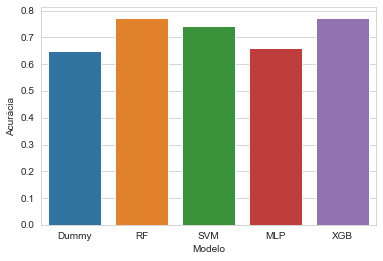

,Modelo,Acurácia
0,Dummy,0.647541
1,RF,0.773770
2,SVM,0.740984
3,MLP,0.662295
4,XGB,0.773770


In [7]:
# Aplicando os modelos baseline
avalia_dif_modelos_cv(X_train, y_train, 10)

### 2.5 - Aplicando feature selection sem balancear os dados;
Vou utilizar o modelo com melhor desempenho para aplicar o feature selection mesmo sem balancear os dados e verificar como o modelo se comporta;

O modelo escolhido foi o RF, pois apresentou o melhor resultado dentre os modelos baseline.

<b> Deve-se criar um novo modelo para evitar leakage, pois o modelo já foi treinado com todos os dados e se for aplicado o feature selection no modelo já treinado, o resultado será enviesado. </b>

In [ ]:
# # Importando o SFFS (Sequential Floating Forward Selection) e SBFS (Sequential Backward Floating Selection)
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS

#### 2.4.1 - Divisão Treino/Teste e Def. da função de avaliação;
A função visa apenas facilitar o processo de teste dos modelos, pois ela já faz o fit do modelo, predição e retorna o classification report. E a matriz de confusão.

In [ ]:
# # Dividindo os dados de treino e teste
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
#
# # Definindo modelo RF
# rf_featSelect_Ub = RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
# # Função para avaliar o comportamento do modelo com o feature selection
# def avalia_modelo(model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     print(classification_report(y_test, y_pred, zero_division=0))
#     print(confusion_matrix(y_test, y_pred))
#     return y_pred

#### (1) SFS - Sequential Forward Selection;

In [ ]:
# # Criando o modelo SFS
# sfs = SFS(rf_featSelect_Ub, k_features='best', forward=True, floating=False, scoring='accuracy', cv=5, n_jobs=-1)
#
# # Aplicando o modelo SFFS
# sfs.fit(X_train, y_train)
#
# # Selecionando as colunas do dataframe de treino
# X_train_sfs = X_train.iloc[:, list(sfs.k_feature_idx_)]
# X_test_sfs = X_test.iloc[:, list(sfs.k_feature_idx_)]
#
# # Aplicando a função de avaliação
# rf_sfs_UB = avalia_modelo(rf_featSelect_Ub, X_train_sfs, y_train, X_test_sfs, y_test)

#### (2) SFFS - Sequential Floating Forward Selection;

In [ ]:
# # Criando o modelo SFFS
# sffs = SFS(rf_featSelect_Ub, k_features='best', forward=True, floating=True, scoring='accuracy', cv=5, n_jobs=-1)
#
# # Aplicando o modelo SFFS
# sffs.fit(X_train, y_train)
#
# # Selecionando as colunas do dataframe de treino
# X_train_sffs = X_train.iloc[:, list(sffs.k_feature_idx_)]
# X_test_sffs = X_test.iloc[:, list(sffs.k_feature_idx_)]
#
# # Aplicando a função de avaliação
# rf_sffs_UB = avalia_modelo(rf_featSelect_Ub, X_train_sffs, y_train, X_test_sffs, y_test)

## 3 - Treinamento dos modelos com os dados balanceados;
Agora vamos treinar os modelos com os dados balanceados e verificar se o desempenho melhora.

### 3.0 - Importando as bibliotecas e definindo as funções;

In [8]:
# Importando as bibliotecas
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliotecas para undersampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import ClusterCentroids

In [9]:
# Dividindo os dados de treino e teste
X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

### 3.1 - Visualizando o balanceamento dos dados;

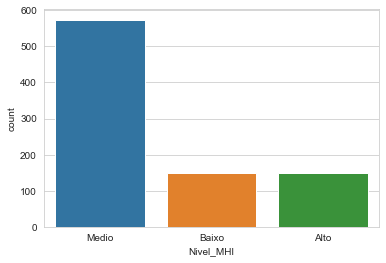

In [10]:
# Plotando o gráfico de barras para verificar o balanceamento dos dados
sns.countplot(x='Nivel_MHI', data=base)
plt.show("Balanceamento dos dados")
%matplotlib inline

### 3.2 - Undersampling;
Neste caso, vamos aproveitar o tamanho da base de dados que temos e vamos reduzir a quantidade de dados da classe majoritária para o mesmo tamanho da classe minoritária.
Tecnicas de undersampling:
- (1) - RandomUnderSampling
- (2) - NearMiss
- (3) - ????


#### (1) - RandomUnderSampling;

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      98.0
           1       0.00      0.00      0.00      98.0
           2       0.00      0.00      0.00      98.0

    accuracy                           0.00     294.0
   macro avg       0.00      0.00      0.00     294.0
weighted avg       0.00      0.00      0.00     294.0

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        98
           1       0.83      0.83      0.83        98
           2       0.65      0.66      0.66        98

    accuracy                           0.77       294
   macro avg       0.77      0.77      0.77       294
weighted avg       0.77      0.77      0.77       294

-------------------

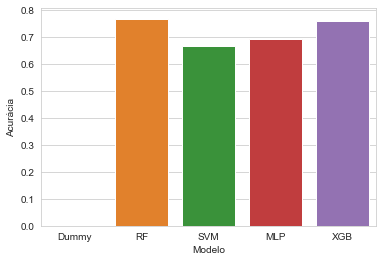

,Modelo,Acurácia
0,Dummy,0.000000
1,RF,0.768707
2,SVM,0.666667
3,MLP,0.693878
4,XGB,0.758503


In [12]:
# Criando o objeto para aplicar o RandomUnderSampling
rus = RandomUnderSampler(random_state=42, replacement=True, sampling_strategy='auto')

# Aplicando o RandomUnderSampling
X_rus, y_rus = rus.fit_resample(X_train_re, y_train_re)

# Plotando o gráfico de barras para verificar o balanceamento dos dados
#sns.countplot(x=y_rus, data=df_socioeconomico)

# Aplicando a função de avaliação cruzada com os dados balanceados
avalia_dif_modelos_cv(X_rus, y_rus, 10)

In [12]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X_rus, y_rus)
y_pred = rf.predict(X_test_re)
print(classification_report(y_test_re, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.55      0.58      0.57        48
           1       0.67      0.92      0.78        51
           2       0.83      0.72      0.77       163

    accuracy                           0.73       262
   macro avg       0.68      0.74      0.70       262
weighted avg       0.75      0.73      0.73       262



#### (2) - NearMiss;

In [ ]:
# Criando o objeto para aplicar o NearMiss
nm = NearMiss(version=1)

# Aplicando o NearMiss
X_nm, y_nm = nm.fit_resample(X_train_re, y_train_re)

# Plotando o gráfico de barras para verificar o balanceamento dos dados
#sns.countplot(x=y_nm, data=df_socioeconomico)

# Aplicando a função de avaliação cruzada com os dados balanceados
avalia_dif_modelos_cv(X_nm, y_nm, 10)

### 3.3 - Oversampling;
Neste caso, vamos aproveitar o tamanho da base de dados que temos e vamos aumentar a quantidade de dados da classe minoritária para o mesmo tamanho da classe majoritária.
Tecnicas de oversampling:
- (1) - Random Over Sampling
- (2) - SMOTE-NC
- (3) - ROSE
- (4) - ADASYN

In [ ]:
# Criando uma função que verifica quais colunas de um dataframe são categoricas e salva os indices em uma lista. Ela faz isso verificando se a coluna conte apenas 1 ou 0.
def verifica_categoricas(df):
    # Criando uma lista vazia para salvar os indices das colunas categóricas
    categorical_features = []

    # Loop para verificar as colunas
    for col in df.columns:
        # Verificando se a coluna conte apenas 1 ou 0, ou True ou False
        if df[col].isin([0, 1]).all() or df[col].isin([True, False]).all():
            # Salvando o indice da coluna na lista
            categorical_features.append(df.columns.get_loc(col))

    # Retornando a lista com os indices das colunas categóricas
    return categorical_features

#### (1) - SMOTE-NC

In [ ]:
# Importando o SMOTE-NC (Synthetic Minority Oversampling Technique for Nominal and Continuous)
from imblearn.over_sampling import SMOTENC

# Definindo as colunas categóricas, chamando a função criada anteriormente
c_features = verifica_categoricas(X)

# Criando o modelo SMOTE
smote = SMOTENC(c_features, random_state=42)

# Aplicando o SMOTE nos dados de treino
X_train_smote, y_train_smote = smote.fit_resample(X_train_re, y_train_re)

avalia_dif_modelos_cv(X_train_smote, y_train_smote, 10)

#### (2) - ROSE
Nesse caso vamos usar 'ROSE', mas é importante ressaltar que teremos dados categoricos e numericos, então vamos usar o rose para dados mistos.

In [ ]:
# Importando o ROSE para dados mistos
from imblearn.over_sampling import RandomOverSampler
# Criando o modelo ROSE
rose = RandomOverSampler(random_state=43)

# Aplicando o ROSE nos dados de treino
X_train_rose, y_train_rose = rose.fit_resample(X_train_re, y_train_re)

# Aplicando a função de avaliação cruzada com os dados balanceados
avalia_dif_modelos_cv(X_train_rose, y_train_rose, 10)


## Aplicando Tecnicas de Tuning (Feature Selection e Hyperparameter Tuning);
- (1) - Feature Selection: SFFS, SFBS
- (2) - Hyperparameter Tuning: GridSearchCV, RandomizedSearchCV

### TPOT para encontrar o melhor modelo para o problema;

In [13]:
# # Importando as bibliotecas necessárias
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Criando o modelo de classificação MLP
rf_SFFS = RandomForestClassifier(n_jobs=-1)
# Criando o objeto SFS
sffs = SFS(rf_SFFS, k_features="best", forward=True, floating=True, scoring='accuracy', cv=5, n_jobs=-1)
# Aplicanod SFFS
sffs.fit(X_rus, y_rus)

SequentialFeatureSelector(estimator=RandomForestClassifier(n_jobs=-1),
                          floating=True, k_features=(1, 84), n_jobs=-1,
                          scoring='accuracy')

In [14]:
# Criando o modelo de classificação para o SBFS
rf_SBFS = RandomForestClassifier(n_jobs=-1)
# Criando o objeto SBFS
sbfs = SFS(rf_SBFS, k_features="best", forward=False, floating=True, scoring='accuracy', cv=5, n_jobs=-1)
# Aplicanod SBFS
sbfs.fit(X_rus, y_rus)

SequentialFeatureSelector(estimator=RandomForestClassifier(n_jobs=-1),
                          floating=True, forward=False, k_features=(1, 84),
                          n_jobs=-1, scoring='accuracy')

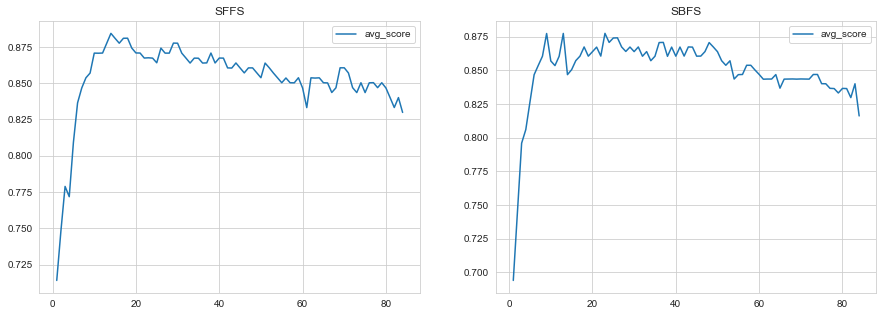

In [15]:
# Plotando o gráfico com os resultados do SFFS vs SBFS para verificar qual deles é melhor considerando que sffs.get_metrics_dict() retorna um dicionário com as métricas de cada iteração no formato numpy.float() e nao tem um atribulo plot()
# Marcar o melhor ponto de cada um no gráfico

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
pd.DataFrame.from_dict(sffs.get_metric_dict()).T[['avg_score']].plot(ax=ax[0], kind='line')
pd.DataFrame.from_dict(sbfs.get_metric_dict()).T[['avg_score']].plot(ax=ax[1], kind='line')
ax[0].set_title('SFFS')
ax[1].set_title('SBFS')
plt.show()

In [16]:
# Imprimindo o melhor score de cada um como um df mostrando apenas os 10 melhores, colunas "Number of Features" e "avg_score"
pd.DataFrame.from_dict(sffs.get_metric_dict()).T[['avg_score']].sort_values(by='avg_score', ascending=False).head(10)

,avg_score
14,0.884278
18,0.880947
17,0.880888
15,0.88083
29,0.877557
30,0.877499
16,0.877499
13,0.877499
19,0.874167
26,0.874109


In [17]:
# Imprimindo o melhor score de cada um como um df mostrando apenas os 10 melhores
pd.DataFrame.from_dict(sbfs.get_metric_dict()).T[['avg_score']].sort_values(by='avg_score', ascending=False).head(10)


,avg_score
23,0.877499
13,0.87744
9,0.877382
26,0.874167
25,0.87405
24,0.870777
37,0.870777
36,0.87066
48,0.87066
49,0.867387


In [18]:
# Imprimindo as features selecionadas por cada um de acordo com o nome original das colunas
print('SFFS: ', X_rus.columns[list(sffs.k_feature_idx_)])
print('SBFS: ', X_rus.columns[list(sbfs.k_feature_idx_)])


SFFS:  Index(['C', 'H', 'M', 'AN', 'AX', 'AZ', 'D_2.0', 'E_2.0', 'E_3.0', 'I_3.0',
       'J_4.0', 'BY', 'CF', 'CS'],
      dtype='object')
SBFS:  Index(['N', 'U', 'AE', 'AN', 'AO', 'AX', 'D_1.0', 'D_2.0', 'D_4.0', 'J_2.0',
       'J_3.0', 'BS', 'BT', 'BW', 'BX', 'BY', 'CD', 'CG', 'CI', 'CJ', 'CO',
       'CQ', 'CR'],
      dtype='object')


### GridSearch para encontrar os melhores parametros para cada modelo;

In [20]:
#SFFS:  Index(['C', 'H', 'M', 'AN', 'AX', 'AZ', 'D_2.0', 'E_2.0', 'E_3.0', 'I_3.0',
#              'J_4.0', 'BY', 'CF', 'CS'],
#             dtype='object')
#SBFS:  Index(['N', 'U', 'AE', 'AN', 'AO', 'AX', 'D_1.0', 'D_2.0', 'D_4.0', 'J_2.0',
#              'J_3.0', 'BS', 'BT', 'BW', 'BX', 'BY', 'CD', 'CG', 'CI', 'CJ', 'CO',
#              'CQ', 'CR'],
#             dtype='object')


# Importando o GridSearch
from sklearn.model_selection import GridSearchCV
if sffs.get_metric_dict()[list(sffs.get_metric_dict().keys())[-1]]['avg_score'] > sbfs.get_metric_dict()[list(sbfs.get_metric_dict().keys())[-1]]['avg_score']:
    # Pegando as colunas selecionadas pelo SFFS
    X_train_gs = X_rus.iloc[:, list(sffs.k_feature_idx_)]
    X_test_re_gs = X_test_re.iloc[:, list(sffs.k_feature_idx_)]
else:
    X_train_gs = X_rus.iloc[:, list(sbfs.k_feature_idx_)]
    X_test_re_gs = X_test_re.iloc[:, list(sbfs.k_feature_idx_)]

# Definindo os parametros para o GridSearch do MLP
param_rf = {
    'n_estimators': [50, 100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False],
    'random_state': [42]
}
# Criando o modelo de classificação
rf_gs = RandomForestClassifier(n_jobs=-1)
# Criando o objeto GridSearch
gs = GridSearchCV(rf_gs, param_rf, scoring='accuracy', cv=5, n_jobs=-1)
# Aplicando o GridSearch
gs.fit(X_train_gs, y_rus)
# Imprimindo os melhores parametros
print('Melhores parametros: ', gs.best_params_)
# Imprimindo o melhor score
print('Melhor score: ', gs.best_score_)


C:\Users\lucas\anaconda3\envs\BIC\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Melhores parametros:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 42}
Melhor score:  0.8706604324956165


In [37]:
from sklearn.model_selection import cross_val_score
# Pegando as colunas selecionadas pelo SFFS e a base balanceada, e utilizanod os dados de teste para testar o modelo com um cross validation de 10 folds
features_sffs = ['C', 'H', 'M', 'AN', 'AX', 'AZ', 'D_2.0', 'E_2.0', 'E_3.0', 'I_3.0', 'J_4.0', 'BY', 'CF', 'CS']
features_sbfs = ['N', 'U', 'AE', 'AN', 'AO', 'AX', 'D_1.0', 'D_2.0', 'D_4.0', 'J_2.0', 'J_3.0', 'BS', 'BT', 'BW', 'BX', 'BY', 'CD', 'CG', 'CI', 'CJ', 'CO', 'CQ', 'CR']
X_train_sffs = X_rus.loc[:, features_sffs]
# Definindo modelo MLP com os parametros encontrados pelo GridSearch
parametors = {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 42}
mlp_best = RandomForestClassifier(**parametors)
# Aplicando o cross validation
scores = cross_val_score(mlp_best, X_train_sffs, y_rus, cv=10, scoring='accuracy')
# Imprimindo resutlados do cross validation em uma tabela do pandas para melhor visualização, mostrando o indice do fold e somente no final a media e o desvio padrão
pd.DataFrame({'Fold': range(1, len(scores) + 1), 'Score': scores})

C:\Users\lucas\anaconda3\envs\BIC\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lucas\anaconda3\envs\BIC\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lucas\anaconda3\envs\BIC\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

,Fold,Score
0,1,0.900000
1,2,0.900000
2,3,0.866667
3,4,0.833333
4,5,0.827586
5,6,0.862069
6,7,0.862069
7,8,0.931034
8,9,0.827586
9,10,0.862069


C:\Users\lucas\anaconda3\envs\BIC\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Acurácia do modelo com tuning:  0.6793893129770993
Acurácia do modelo sem tuning:  0.6603053435114504


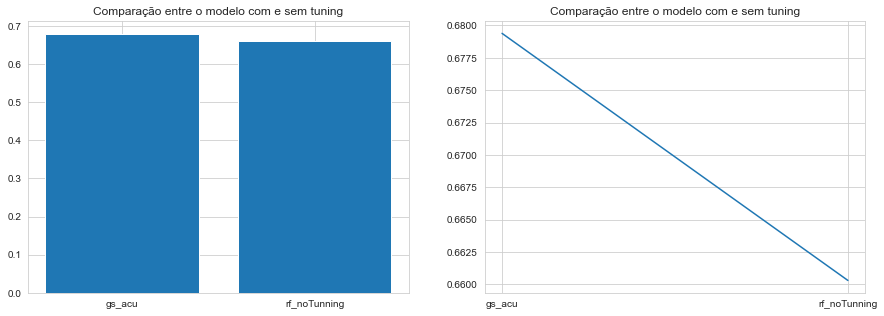

In [21]:
#Melhores parametros:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 42}
#Melhor score:  0.8706604324956165

# Criando Grafico comparando os resultados do Modelo Sem Tuning e com Tuning

# Pegando os melhores parametros
rf_best = gs.best_estimator_

rf_best.fit(X_train_gs, y_rus)
rf_best.predict(X_test_re_gs)
gs_acu = accuracy_score(y_test_re, rf_best.predict(X_test_re_gs))
print('Acurácia do modelo com tuning: ', gs_acu)

# Testando modelo sem tuning
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train_gs, y_rus)
rf.predict(X_test_re_gs)
rf_noTunning = accuracy_score(y_test_re, rf.predict(X_test_re_gs))
print('Acurácia do modelo sem tuning: ', rf_noTunning)
# Grafico comparando os resultados
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plotando de barra gs_acu vs rf_noTunning
ax[0].bar(['gs_acu', 'rf_noTunning'], [gs_acu, rf_noTunning])
ax[0].set_title('Comparação entre o modelo com e sem tuning')
# Plotando de linha gs_acu vs rf_noTunning
ax[1].plot(['gs_acu', 'rf_noTunning'], [gs_acu, rf_noTunning])
ax[1].set_title('Comparação entre o modelo com e sem tuning')
plt.show()

In [22]:
# Importando o TPOT
#from tpot import TPOTClassifier
# Criando o modelo TPOT limitando o tempo de execução em 25 minutos e modelos simples
#tpot = TPOTClassifier(verbosity=2, max_time_mins=60)
# # Treinando o modelo
#tpot.fit(X_rus, y_rus)

# Imprimindo os 3 melhores modelos
#tpot.fitted_pipeline_

# Pegando o melhor modelo
#tpot.fitted_pipeline_.steps[-1][1]
# Fazendo as previsões
#y_pred_tpot = tpot.predict(X_test)

In [23]:
# # Fazendo as previsões
#y_pred_tpot = tpot.predict(X_test)
#
# # Avaliando o modelo
#print(classification_report(y_test, y_pred_tpot))
#print(confusion_matrix(y_test, y_pred_tpot))
